# 1. Definition

In [1]:
import bisect
import numpy as np
from os.path import exists
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs

In [2]:
def load(path):
    print(f"{path}: exist? => {exists(path)}")
    npy = np.load(path)
    return npy

def make_boundaries(data, class_num=5, models=42, years=165, grids=20*20):
    mjjaso = data.copy() # data(42, 165, lat_grid, lon_grid)
    flat = mjjaso.reshape(models*years*grids)
    flat_sorted = np.sort(flat)
    if len(flat_sorted)%class_num != 0:
        print('class_num is wrong')
    else:
        batch_sample = int(len(flat_sorted)/class_num)
        
    bnd = [flat_sorted[i] for i in range(0, len(flat_sorted), batch_sample)]
    bnd.append(flat_sorted[-1] + 1e-10) # max boundary must be a bit higher than real max
    bnd[0] = bnd[0] - 1e-10 # min boundary must be a bit higher than real min
    bnd = np.array(bnd)
    
    return flat, bnd

def one_EFD(data, class_num=5, models=42, years=165):
    flat, bnd = make_boundaries(data, class_num=class_num, models=models, years=years, gids=1)

    one_class = np.empty(len(flat))
    for i, value in enumerate(flat):
        label = bisect.bisect(bnd, value)
        one_class[i] = int(label - 1)
    one_class.rehsape(models, years)
    return one_class, bnd
    
def thailand_EFD(data, class_num=5, models=42, years=165, lat_grid=20, lon_grid=20):
    # EFD_bnd
    mjjaso_thailand = data.copy() # data = (42, 165, 20, 20)
    flat, bnd = make_boundaries(data, class_num=class_num, models=models, years=years, grids=lat_grid*lon_grid)
    
    thailand_class = np.empty(data.shape)
    for lat in range(lat_grid):
        for lon in range(lon_grid):
            grid = mjjaso_thailand[:, :, lat, lon].reshape(models*years)
            grid_class = np.empty(len(grid))
            for i, value in enumerate(grid):
                label = bisect.bisect(bnd, value)
                grid_class[i] = int(label - 1)
            grid_class = grid_class.reshape(models, years)
            thailand_class[:, :, lat, lon] = grid_class
    return thailand_class, bnd

# 2. Load

In [3]:
def thailand_resolution(resolution):
    if resolution == '1x1':
        lat_grid, lon_grid = 20, 20
        key = '1x1'
    elif resolution == '5x5':
        lat_grid, lon_grid = 4, 4
        key = '5x5_coarse'
    return key, lat_grid, lon_grid

# setting
resolution = '1x1'
key, lat_grid, long_gird = thailand_resolution(resolution)
month = 'MJJASO'

work = '/docker/mnt/d/research/D2/cnn3/predictant/continuous/'
onepath = work + f"pr_{key}_std_{month}_one.npy"
thailandpath = work + f"pr_{key}_std_{month}_thailand.npy"

thailand = load(thailandpath)
print(thailand.shape)

/docker/mnt/d/research/D2/cnn3/predictant/continuous/pr_1x1_std_MJJASO_thailand.npy: exist? => True
(42, 165, 20, 20)


# 3. Thailadn EFD

In [4]:
thailand_class, bnd = thailand_EFD(thailand,
                                   class_num=5,
                                   models=42,
                                   years=165,
                                   lat_grid=20,
                                   lon_grid=20)
print(thailand.shape)
print(thailand_class.shape)
print(bnd)

(42, 165, 20, 20)
(42, 165, 20, 20)
[-3.42209629 -0.34381695 -0.11536562  0.08793853  0.33505367  2.72356614]


# 4. Plot

In [17]:
def draw_discreted_hist(data, bnd_list, class_num=5):
    # color map
    cmap = plt.cm.get_cmap('BrBG', class_num)
    # cmap.N = 5
    # cmap(0) = (R, G, B, alpha)    
    
    # plot
    fig = plt.figure()
    ax = plt.subplot()
    ax = fig.add_axes([0.05, 0.2, 0.9, 0.7])
    ax1 = fig.add_axes([0.05, 0.05, 0.9, 0.075])
    
    # n: number of counts in each bin of the histgram
    # bins: is the left hand edge of each bin
    # patches: collection of rectangles
    ht, bins, patches = ax.hist(data,
                                bins=100, # 400oder, bin=40000
                                )
    
    # make criteria for bins
    print(bnd_list)
    print(bins)
    bin_bnd = []
    for criteria in bnd_list:
        for index, bn in enumerate(bins):
            if bn > criteria:
                bin_bnd.append(index)
                break
    bin_bnd.append(-1)
    
    # color histgram
    for b, c in zip(range(len(bin_bnd)),
                    range(cmap.N)):
        if b != len(bin_bnd) - 1:
            plt.setp(patches[bin_bnd[b] : bin_bnd[b+1]],
                     'facecolor',
                     cmap(c)
                     )
        else:
            plt.setp(patches[bin_bnd[-2] : bin_bnd[-1]],
                     'facecolor',
                     cmap(4)
                     )
            
            
    # draw colorbar
    #bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
    bounds = [round(bnd_list[i], 2) for i in range(6)]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    cb1 = mpl.colorbar.ColorbarBase(ax1,
                                    cmap=cmap,
                                    norm=norm,
                                    orientation='horizontal'
                                    )
    if class_num == 5:
        label = [f"{round(bnd_list[0], 2)}",
                 f"{round(bnd_list[1], 2)}",
                 f"{round(bnd_list[2], 2)}",
                 f"{round(bnd_list[3], 2)}",
                 f"{round(bnd_list[4], 2)}",
                 f"{round(bnd_list[5], 2)}",]
        cb1.ax.set_xticklabels(label)
    plt.show()

[-3.42209629 -0.34381695 -0.11536562  0.08793853  0.33505367  2.72356614]
[-3.42209629 -3.36063967 -3.29918305 -3.23772642 -3.1762698  -3.11481317
 -3.05335655 -2.99189992 -2.9304433  -2.86898667 -2.80753005 -2.74607343
 -2.6846168  -2.62316018 -2.56170355 -2.50024693 -2.4387903  -2.37733368
 -2.31587706 -2.25442043 -2.19296381 -2.13150718 -2.07005056 -2.00859393
 -1.94713731 -1.88568069 -1.82422406 -1.76276744 -1.70131081 -1.63985419
 -1.57839756 -1.51694094 -1.45548432 -1.39402769 -1.33257107 -1.27111444
 -1.20965782 -1.14820119 -1.08674457 -1.02528794 -0.96383132 -0.9023747
 -0.84091807 -0.77946145 -0.71800482 -0.6565482  -0.59509157 -0.53363495
 -0.47217833 -0.4107217  -0.34926508 -0.28780845 -0.22635183 -0.1648952
 -0.10343858 -0.04198196  0.01947467  0.08093129  0.14238792  0.20384454
  0.26530117  0.32675779  0.38821441  0.44967104  0.51112766  0.57258429
  0.63404091  0.69549754  0.75695416  0.81841079  0.87986741  0.94132403
  1.00278066  1.06423728  1.12569391  1.18715053  1.

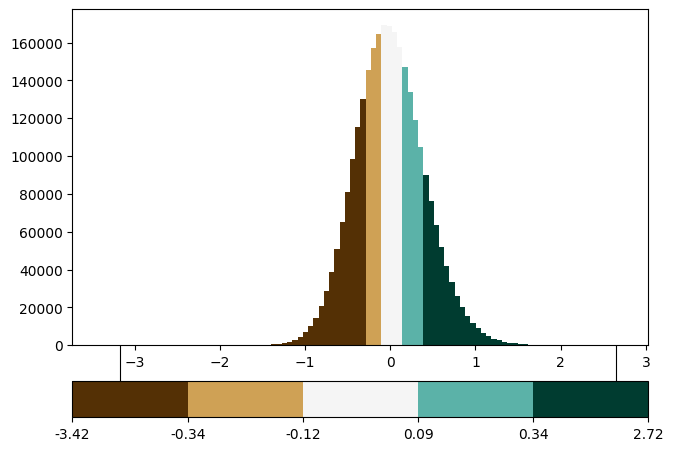

In [18]:
thailand_flat = thailand.reshape(42*165*20*20)
draw_discreted_hist(thailand_flat, bnd, class_num=5)